In [1]:
#libraries we want to use 

import os
import pandas as pd
import sklearn
import warnings
import plotly.express as px
import re
import nltk.corpus #pip install nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from gensim.models import Word2Vec 
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
warnings.filterwarnings("ignore")
import torch 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/khadidjahrn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#import the csv with the database we are going to use

df = pd.read_csv('/Users/khadidjahrn/Downloads/AssignmentTransformers/data_tweet_sample_challenge.csv')
df.head()

,id,created_at,text,attachments.media,attachments.media_keys,attachments.poll.duration_minutes,attachments.poll.end_datetime,attachments.poll.id,attachments.poll.options,attachments.poll.voting_status,...,source,withheld.scope,withheld.copyright,withheld.country_codes,type,__twarc.retrieved_at,__twarc.url,__twarc.version,conversation_search,label
0,1075677468294635522,2018-12-20T09:01:08.000Z,RT @GameCentral: Borderlands 2 VR and it's rou...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,TweetDeck,NaN,NaN,NaN,NaN,2022-08-25T13:05:45+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.10.2,conversation_id:1075677468294635522,en
1,670304079214702592,2015-11-27T18:12:00.000Z,This is 'the world’s sexiest robot’... apparen...,"[{""width"": 1024, ""type"": ""photo"", ""media_key"":...","[""3_670304079109844992""]",NaN,NaN,NaN,NaN,NaN,...,Sprinklr,NaN,NaN,NaN,NaN,2022-08-25T13:04:56+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.10.2,conversation_id:670304079214702592,en
2,1085566226116628480,2019-01-16T15:55:31.000Z,Un antepasado del que no sabíamos nada 👴👵 #cie...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Besocy_Oficial,NaN,NaN,NaN,NaN,2022-08-25T16:43:04+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.10.2,conversation_id:1085566226116628480,es
3,968059526594420736,2018-02-26T09:45:51.000Z,"Im neuen #Porsche ""Mission E"" steckt die Block...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,TweetDeck,NaN,NaN,NaN,retweeted,2022-08-25T16:13:46+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.10.2,conversation_id:968059526594420736,de
4,784508641508483072,2016-10-07T21:40:10.000Z,Tweede Wereldoorlog in virtual reality herbele...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Buffer,NaN,NaN,NaN,NaN,2022-08-25T16:20:22+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.10.2,conversation_id:784508641508483072,nl


In [3]:
#Keeping the main variables only

df = df[['id','created_at','text', 'author.id', 'public_metrics.like_count', 'public_metrics.retweet_count', 'label', 'author.name']]
print(df)

                       id                created_at  \
0     1075677468294635522  2018-12-20T09:01:08.000Z   
1      670304079214702592  2015-11-27T18:12:00.000Z   
2     1085566226116628480  2019-01-16T15:55:31.000Z   
3      968059526594420736  2018-02-26T09:45:51.000Z   
4      784508641508483072  2016-10-07T21:40:10.000Z   
...                   ...                       ...   
2995   363143812530466816  2013-08-02T03:46:46.000Z   
2996  1044181853312176130  2018-09-24T11:08:48.000Z   
2997   788069634599587840  2016-10-17T17:30:17.000Z   
2998   880863441908625408  2017-06-30T18:59:44.000Z   
2999   720610688255795200  2016-04-14T13:52:31.000Z   

                                                   text  author.id  \
0     RT @GameCentral: Borderlands 2 VR and it's rou...  138749160   
1     This is 'the world’s sexiest robot’... apparen...   34655603   
2     Un antepasado del que no sabíamos nada 👴👵 #cie...   38640768   
3     Im neuen #Porsche "Mission E" steckt die Block...   5

In [4]:
#Translate other languages to english
from googletrans import Translator #!pip install googletrans
from tqdm import tqdm


translator = Translator()

def translate_to_english(text, language):
    if language != 'en':
        try:
            translation = translator.translate(text, src=language, dest='en')
            return translation.text
        except Exception as e:
            return text
    else:
        return text

tqdm.pandas()

df['text'] = df.progress_apply(lambda row: translate_to_english(row['text'], row['label']), axis=1)

100%|██████████| 3000/3000 [11:57<00:00,  4.18it/s]


In [5]:
# Function to extract hashtags and their following words

def extract_hashtags(text):
    hashtags = re.findall(r'#\w+', text)
    return " ".join(hashtags)

# Apply the function to create the "hashtag" column
df['hashtag'] = df['text'].apply(extract_hashtags)

In [22]:
#Text cleaning

stop = stopwords.words('english')
stop.append('rt') # to add 'retweet' to the stop function 
no_rt  = ['rt']

def cleaning(text):
    text = text.lower()
    text = re.sub("\[.*?\]","",text)
    text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+", "", text)
    text = " ".join([word for word in text.split() if word is not 'rt'])
    return text

df['cleaned_text'] = df['text'].apply(cleaning)

In [6]:
#Plot showing the distribution of tweets over time

df['date_M'] = df['created_at'].apply(lambda x:x[:7])
fig = px.line(df.groupby('date_M').count(), y=df.groupby('date_M').count()['author.name'].values, x=df.groupby('date_M').count().index)
fig.update_layout(plot_bgcolor = "white")
fig.update_layout(
    title="Distribution of Tweetss over time",
    xaxis_title="Years",
    yaxis_title="Number_tweets",
    font=dict(
         size=12,
        color="Black"
    ),
    plot_bgcolor = "white"
)
fig.update_traces(line=dict(width=2, color='green'))

fig.show()

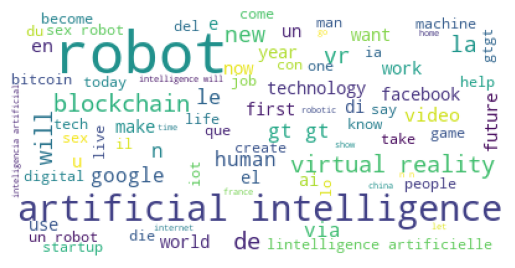

In [23]:
#from wordcloud import WordCloud  
#import matplotlib.pyplot as plt  

text = ' '.join(x for x in df['cleaned_text'].values)


wordcloud = WordCloud(background_color = 'white', max_words = 80).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

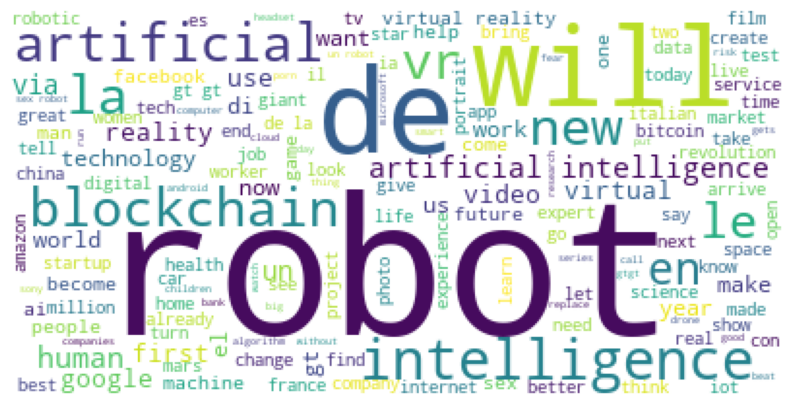

In [26]:
c_vec = CountVectorizer(ngram_range=(2,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(df['cleaned_text'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
vocab = c_vec.vocabulary_df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
# let's put everything in onle list for our wordcloud!
tweet_string_list = vocab['bigram/trigram'].str.replace(' ','.').tolist()
tweet_string = ' '.join(tweet_string_list)

wordcloud = WordCloud(background_color = 'white', max_words = 500).generate(tweet_string)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud)
plt.axis("off")

plt.show()

In [27]:
# we want to create a dataframe that has all the variables grouped by author to facilitate the extraction of the top 5 authors by countries. 
#For that, we create a new data frame with the sum of the likes and retweets for each author respectfully and the number of the total number of their tweets

likes_by_authors = df.groupby(['author.name'])['public_metrics.like_count'].sum().groupby(level=0).head(5) # total likes by authors

rt_by_authors = df.groupby(['author.name'])['public_metrics.retweet_count'].sum().groupby(level=0).head(5) #total retweets by authors

label_by_authors = df.groupby(['author.name'])['label'].unique() # retrieve the label (country/language) of each author

author_counts = df['author.name'].value_counts() # number of tweets made by each authors

#creation of the new new data frame
combined_top_authors = pd.concat([likes_by_authors, rt_by_authors, label_by_authors, author_counts], axis=1)
combined_top_authors.reset_index(inplace=True)

# Renaming the columns
combined_top_authors.columns = ['author.name','likes', 'retweets', 'label', 'counts']
combined_top_authors_df = pd.DataFrame(combined_top_authors)

print(combined_top_authors_df)


             author.name  likes  retweets label  counts
0             7 Corriere      8         5  [it]       1
1                 ABC.es    579       709  [es]      62
2                AD Show      1         9  [nl]       2
3                  AD.nl      4        25  [nl]       8
4                 AMETIC      0         2  [es]       1
..                   ...    ...       ...   ...     ...
272                  taz     20         7  [de]       3
273        tizianapollio      4         5  [it]       1
274                verne     94        97  [es]       1
275             𝐀𝐯𝐯𝐞𝐧𝐢𝐫𝐞     70       175  [it]      14
276  🅰️ziliz de Veyrinas      2         8  [fr]       1

[277 rows x 5 columns]


In [28]:
author_counts = df['author.name'].value_counts()
author_counts

author.name
Les Echos            239
Repubblica           212
La Stampa            166
The Mirror           147
Le Figaro            146
                    ... 
Times Technology       1
Repubblica Motori      1
Philipp Krohn          1
Nicolas Rauline        1
BuntPlanet             1
Name: count, Length: 277, dtype: int64

In [29]:

author_counts = df['author.name'].value_counts()

#retrieve the top 5 authors with the most tweets by countries 

top_authors_by_label = df.groupby(['label'])['author.name'].value_counts().groupby(level=0).head(5) 
top_authors_by_label_df = top_authors_by_label.reset_index()

new_df = top_authors_by_label_df[['label','author.name', 'count']]
top_authors_by_label_df


,label,author.name,count
0,de,Handelsblatt,59
1,de,WELT,37
2,de,Martin Heller,18
3,de,Felix Holtermann,12
4,de,Frankfurter Allgemeine,10
5,en,The Mirror,147
6,en,The Guardian,142
7,en,Daily Mail Online,95
8,en,The Sun,81
9,en,Mirror Tech,64


In [30]:
#import pandas as pd

top_authors_by_label = df.groupby('label')['author.name'].value_counts().groupby(level=0).head(5).reset_index()

# to keep all the tweets made by the top 5 authors sso that we can analyse them
result = df.merge(top_authors_by_label, on=['label', 'author.name'], how='inner')

result.head(10)


,id,created_at,text,author.id,public_metrics.like_count,public_metrics.retweet_count,label,author.name,date_M,cleaned_text,count
0,670304079214702592,2015-11-27T18:12:00.000Z,This is 'the world’s sexiest robot’... apparen...,34655603,3,5,en,The Sun,2015-11,this is the worlds sexiest robot apparently,81
1,568474210881937408,2015-02-19T18:16:28.000Z,"Feeling peckish during your run? Never fear, t...",34655603,2,2,en,The Sun,2015-02,feeling peckish during your run never fear the...,81
2,1056602259503620097,2018-10-28T17:43:04.000Z,Huge change coming for learner drivers that wi...,34655603,3,2,en,The Sun,2018-10,huge change coming for learner drivers that wi...,81
3,835610829131288581,2017-02-25T22:02:01.000Z,Everything you need to know about Robot sex do...,34655603,4,4,en,The Sun,2017-02,everything you need to know about robot sex dolls,81
4,825463968806338560,2017-01-28T22:02:01.000Z,"Meet Harmony, the first sex robot to offer an ...",34655603,2,6,en,The Sun,2017-01,meet harmony the first sex robot to offer an e...,81
5,1199948538559549440,2019-11-28T07:10:00.000Z,Robot surprises man with ‘Thank You’ https://t...,34655603,8,2,en,The Sun,2019-11,robot surprises man with thank you,81
6,862680639308517377,2017-05-11T14:47:46.000Z,RT @TheSunTech: Would you wear a virtual reali...,34655603,0,1,en,The Sun,2017-05,would you wear a virtual reality helmet during...,81
7,1140525137038626817,2019-06-17T07:42:37.000Z,Susanna Reid gets freaked out by robot that LO...,34655603,10,0,en,The Sun,2019-06,susanna reid gets freaked out by robot that lo...,81
8,896036490152726528,2017-08-11T15:52:01.000Z,Tech experts predict what the world will be li...,34655603,2,1,en,The Sun,2017-08,tech experts predict what the world will be li...,81
9,1076075079358914560,2018-12-21T11:21:06.000Z,ISIS threatens drone attacks against West afte...,34655603,4,9,en,The Sun,2018-12,isis threatens drone attacks against west afte...,81


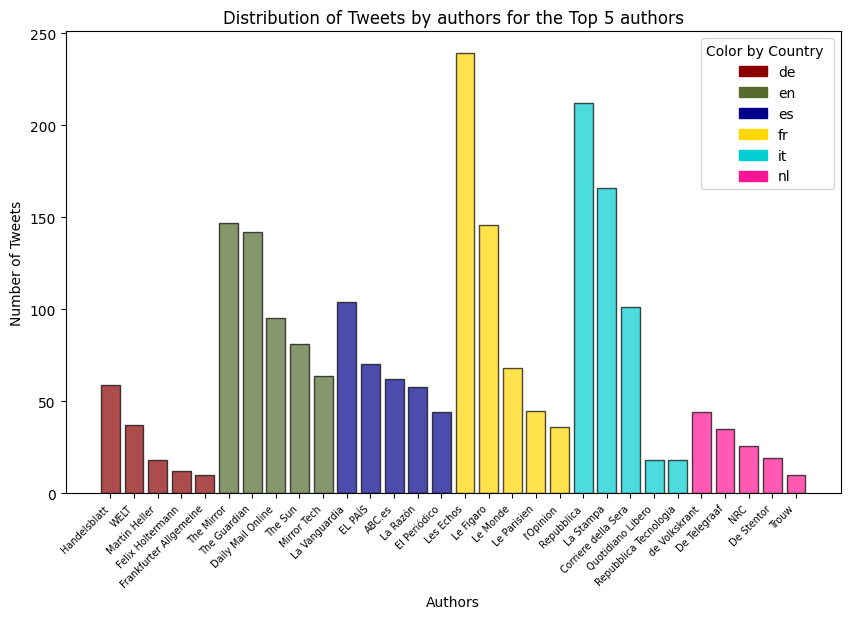

In [18]:

import matplotlib.patches as mpatches

labels = top_authors_by_label_df['label']
authors = top_authors_by_label_df['author.name']
tweets_counts = top_authors_by_label_df['count']

label_colors = {
    'de': 'darkred', 
    'en': 'darkolivegreen',  
    'es': 'darkblue',  
    'fr': 'gold',
    'it': 'darkturquoise',
    'nl': 'deeppink',
}

bar_colors = [label_colors[label] for label in labels]
legend_label = ['de','en','es','fr','it','nl']
color_label = ['darkred', 'darkolivegreen','darkblue', 'gold', 'darkturquoise', 'deeppink' ]

plt.figure(figsize=(10, 6))
bars = plt.bar(authors, tweets_counts, color=bar_colors, alpha=0.7, edgecolor='k')
plt.title('Distribution of Tweets by authors for the Top 5 authors', fontdict= {'family': 'Verdana', 'size' : 12})
plt.xlabel('Authors')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.xticks(ticks= authors, ha='right', fontsize=7)

legend_handles = [mpatches.Patch(color=c, label=labels) for c, labels in zip(color_label, legend_label)]
plt.legend(handles=legend_handles, title = "Color by Country ")


plt.show()

In [31]:
import spacy

# Load the English NER model from spaCy
nlp = spacy.load("en_core_web_sm")

# Define a function to extract named entities from a tweet
def extract_entities(tweet):
    doc = nlp(tweet)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Apply the NER function to your tweets
result['entities'] = result['cleaned_text'].apply(extract_entities)

In [34]:
sample_tweet_entities = result['entities'][0]

for entity, entity_type in sample_tweet_entities:
    print(f"Entity: {entity}, Type: {entity_type}")

for entities in result['entities']:
    for entity, entity_type in entities:
        print(f"Entity: {entity}, Type: {entity_type}")

Entity: first, Type: ORDINAL
Entity: susanna reid, Type: PERSON
Entity: 2025, Type: DATE
Entity: gatwick airport, Type: FAC
Entity: first, Type: ORDINAL
Entity: first, Type: ORDINAL
Entity: 3d, Type: CARDINAL
Entity: five, Type: CARDINAL
Entity: lara croft, Type: PERSON
Entity: russia, Type: GPE
Entity: mark zuckerberg, Type: PERSON
Entity: robot barista, Type: PERSON
Entity: morning, Type: TIME
Entity: google, Type: ORG
Entity: lidl, Type: PERSON
Entity: ford, Type: ORG
Entity: one, Type: CARDINAL
Entity: the beginning of the end, Type: DATE
Entity: trumps, Type: PERSON
Entity: moments, Type: TIME
Entity: porn star, Type: ORG
Entity: first, Type: ORDINAL
Entity: 27, Type: CARDINAL
Entity: first, Type: ORDINAL
Entity: google, Type: ORG
Entity: one million, Type: CARDINAL
Entity: british, Type: NORP
Entity: first, Type: ORDINAL
Entity: mark zuckerberg, Type: PERSON
Entity: lidl, Type: PERSON
Entity: first, Type: ORDINAL
Entity: 2070, Type: DATE
Entity: saira khan, Type: PERSON
Entity: t

In [36]:
from collections import Counter

# Compter le nombre total d'entités
all_entities = [entity_type for entities in result['entities'] for _, entity_type in entities]
total_entities_count = len(all_entities)

# Compter le nombre d'entités de chaque type
entity_counter = Counter(all_entities)

# Calculer la probabilité de chaque type d'entité
entity_probabilities = {}
for entity_type, count in entity_counter.items():
    probability = count / total_entities_count
    entity_probabilities[entity_type] = probability

# Afficher les probabilités
for entity_type, probability in entity_probabilities.items():
    print(f"Entity Type: {entity_type}, Probability: {probability:.4f}")

Entity Type: ORDINAL, Probability: 0.0532
Entity Type: PERSON, Probability: 0.2130
Entity Type: DATE, Probability: 0.0977
Entity Type: FAC, Probability: 0.0082
Entity Type: CARDINAL, Probability: 0.1570
Entity Type: GPE, Probability: 0.1383
Entity Type: TIME, Probability: 0.0132
Entity Type: ORG, Probability: 0.1992
Entity Type: NORP, Probability: 0.0823
Entity Type: QUANTITY, Probability: 0.0088
Entity Type: EVENT, Probability: 0.0022
Entity Type: PRODUCT, Probability: 0.0088
Entity Type: LOC, Probability: 0.0121
Entity Type: MONEY, Probability: 0.0049
Entity Type: PERCENT, Probability: 0.0011


In [37]:
#import pandas as pd

# Créer un DataFrame à partir des probabilités
entity_probabilities_df = pd.DataFrame(list(entity_probabilities.items()), columns=['Entity Type', 'Probability'])

# Trier le DataFrame par probabilité décroissante
entity_probabilities_df = entity_probabilities_df.sort_values(by='Probability', ascending=False)

print(entity_probabilities_df)


   Entity Type  Probability
1       PERSON     0.212953
7          ORG     0.199232
4     CARDINAL     0.156970
5          GPE     0.138310
2         DATE     0.097695
8         NORP     0.082327
0      ORDINAL     0.053238
6         TIME     0.013172
12         LOC     0.012075
9     QUANTITY     0.008782
11     PRODUCT     0.008782
3          FAC     0.008233
13       MONEY     0.004940
10       EVENT     0.002195
14     PERCENT     0.001098


In [38]:
from transformers import pipeline
import pandas as pd

model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

# Iterate through the 'cleaned_text' column and analyze sentiment for each text
sentiments = [sentiment_task(text) for text in result['cleaned_text']]

# 'sentiments' will be a list of sentiment analysis results for each text
sentiments_df = pd.DataFrame(sentiments)

print(sentiments_df)

2023-10-21 19:23:19.237119: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                      0
0     {'label': 'positive', 'score': 0.7245307564735...
1     {'label': 'negative', 'score': 0.4074510931968...
2     {'label': 'positive', 'score': 0.7931544184684...
3     {'label': 'neutral', 'score': 0.7532505989074707}
4     {'label': 'neutral', 'score': 0.44772499799728...
...                                                 ...
2181  {'label': 'positive', 'score': 0.4887889623641...
2182  {'label': 'positive', 'score': 0.4718523919582...
2183  {'label': 'negative', 'score': 0.6131367087364...
2184   {'label': 'neutral', 'score': 0.767163872718811}
2185  {'label': 'neutral', 'score': 0.6772550344467163}

[2186 rows x 1 columns]


In [39]:
#from transformers import pipeline
#import pandas as pd

# Load the sentiment analysis pipeline
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

# Initialize an empty dictionary to store results by 'author.name'
sentiments_by_author = {}

# Iterate through the DataFrame and get sentiment results for each 'author.name'
for index, row in result.iterrows():
    author_name = row['author.name']
    text = row['cleaned_text']
    
    # Perform sentiment analysis
    sentiment_result = sentiment_task(text)
    
    # Add the sentiment result to the dictionary under the 'author.name' key
    if author_name in sentiments_by_author:
        sentiments_by_author[author_name].append(sentiment_result)
    else:
        sentiments_by_author[author_name] = [sentiment_result]

# 'sentiments_by_author' contains sentiment analysis results grouped by 'author.name'


In [40]:
sentiments_by_author

{'The Sun': [[{'label': 'positive', 'score': 0.7245307564735413}],
  [{'label': 'negative', 'score': 0.4074510931968689}],
  [{'label': 'positive', 'score': 0.7931544184684753}],
  [{'label': 'neutral', 'score': 0.7532505989074707}],
  [{'label': 'neutral', 'score': 0.44772499799728394}],
  [{'label': 'positive', 'score': 0.6163817644119263}],
  [{'label': 'neutral', 'score': 0.6240712404251099}],
  [{'label': 'negative', 'score': 0.6163212656974792}],
  [{'label': 'neutral', 'score': 0.6845529079437256}],
  [{'label': 'negative', 'score': 0.879035234451294}],
  [{'label': 'neutral', 'score': 0.4666423797607422}],
  [{'label': 'negative', 'score': 0.7719120383262634}],
  [{'label': 'neutral', 'score': 0.5686644315719604}],
  [{'label': 'neutral', 'score': 0.5267877578735352}],
  [{'label': 'neutral', 'score': 0.5267877578735352}],
  [{'label': 'neutral', 'score': 0.49316713213920593}],
  [{'label': 'positive', 'score': 0.48544377088546753}],
  [{'label': 'neutral', 'score': 0.671786963

In [41]:
from tqdm import tqdm 
lista = []
for i in tqdm(sentiments_by_author.keys()):
   for j in range(len(sentiments_by_author[i])):
       lista.append([i,sentiments_by_author[i][j][0]["label"]])
    

100%|██████████| 30/30 [00:00<00:00, 4659.82it/s]


In [42]:
lista= pd.DataFrame(lista)
lista = lista.rename(columns={0 : 'author.name', 1: 'sentiment'})
print(lista)


                 author.name sentiment
0                    The Sun  positive
1                    The Sun  negative
2                    The Sun  positive
3                    The Sun   neutral
4                    The Sun   neutral
...                      ...       ...
2181  Frankfurter Allgemeine  positive
2182  Frankfurter Allgemeine  positive
2183  Frankfurter Allgemeine  negative
2184  Frankfurter Allgemeine   neutral
2185  Frankfurter Allgemeine   neutral

[2186 rows x 2 columns]


In [43]:
# Map sentiment labels to numerical values
sentiment_mapping = {'positive': 1, 'negative': -1, 'neutral': 0}
lista['sentiment_score'] = lista['sentiment'].map(sentiment_mapping)
print(lista)

                 author.name sentiment  sentiment_score
0                    The Sun  positive                1
1                    The Sun  negative               -1
2                    The Sun  positive                1
3                    The Sun   neutral                0
4                    The Sun   neutral                0
...                      ...       ...              ...
2181  Frankfurter Allgemeine  positive                1
2182  Frankfurter Allgemeine  positive                1
2183  Frankfurter Allgemeine  negative               -1
2184  Frankfurter Allgemeine   neutral                0
2185  Frankfurter Allgemeine   neutral                0

[2186 rows x 3 columns]


In [44]:
# Group by author and calcul of the average sentiment score
average_sentiment_by_author = lista.groupby('author.name')['sentiment_score'].mean().reset_index()

# Rename the 'sentiment_score' column to 'average_sentiment'
average_sentiment_by_author = average_sentiment_by_author.rename(columns={'sentiment_score': 'average_sentiment'})

print(average_sentiment_by_author)



               author.name  average_sentiment
0                   ABC.es           0.000000
1      Corriere della Sera          -0.089109
2        Daily Mail Online          -0.021053
3               De Stentor          -0.157895
4             De Telegraaf          -0.171429
5                  EL PAÍS          -0.042857
6             El Periódico          -0.068182
7         Felix Holtermann          -0.250000
8   Frankfurter Allgemeine           0.200000
9             Handelsblatt          -0.033898
10                La Razón           0.034483
11               La Stampa          -0.018072
12           La Vanguardia           0.067308
13               Le Figaro           0.041096
14                Le Monde          -0.191176
15             Le Parisien          -0.022222
16               Les Echos          -0.025105
17           Martin Heller           0.055556
18             Mirror Tech           0.062500
19                     NRC          -0.076923
20       Quotidiano Libero        

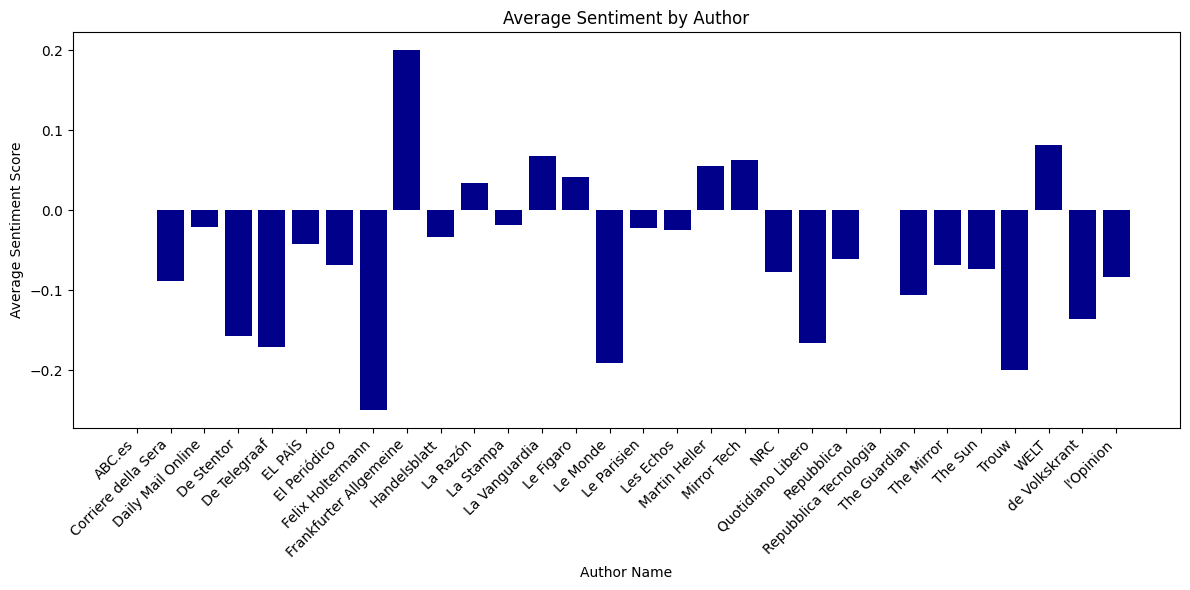

In [45]:
#plot on the average sentiment by authors for the top 5 authors of each country

plt.figure(figsize=(12, 6))
plt.bar(average_sentiment_by_author['author.name'], average_sentiment_by_author['average_sentiment'],color = 'darkblue')
plt.xticks(rotation=45, ha = 'right' ) 

# Labels and a title
plt.xlabel('Author Name')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment by Author')


plt.tight_layout()
plt.show()